# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 05.10.2021

Мягкий дедлайн: 23:59MSK 19.10.2021

Жесткий дедлайн: 23:59MSK 23.10.2021

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ &mdash; полная оценка за работу без учета штрафа, а $t$ &mdash; время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше **8.5**, а если сдать перед самым жестким дедлайном, то ваш максимум &mdash; **5.22** балла.

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
#!pip install torch

In [ ]:
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-23 18:56:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  67.4MB/s    in 3.0s    

2021-10-23 18:56:08 (67.4 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 9.5102


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знайте, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
X_train.astype(np.float32)
X_test.astype(np.float32)

y_train.astype(np.float32)
y_test.astype(np.float32)

array([2007., 2003., 2005., ..., 2006., 2006., 2005.], dtype=float32)

In [ ]:
#Отнормируем признаки
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

ss2 = StandardScaler()
y_train = ss2.fit_transform(y_train[:, None]).reshape(-1)
y_test = ss2.transform(y_test[:, None]).reshape(-1)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
SEED = 101
LR = 0.0015
NUM_EPOCHS = 9
GAMMA = 0.9999
BATCH_SIZE = 128
DEVICE = 'cpu'

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
train_dl = DataLoader(
    MyDataset(X_train, y_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dl = DataLoader(
    MyDataset(X_test, y_test),
    batch_size = BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'test': test_dl}

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.sequential = nn.Sequential(
            nn.Linear(90, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

In [ ]:
set_random_seed(SEED)
model = Model()
model.to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

  0%|          | 0/9 [00:00<?, ?it/s]

,Epoch,Train RMSE,Test RMSE
0,0,9.128887,8.891346


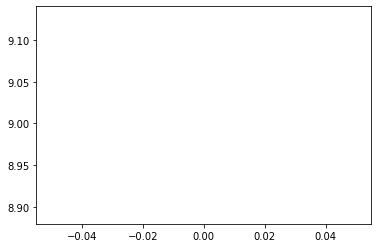

,Epoch,Train RMSE,Test RMSE
1,1,8.904771,8.820286


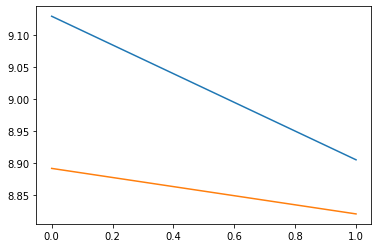

,Epoch,Train RMSE,Test RMSE
2,2,8.838129,8.809372


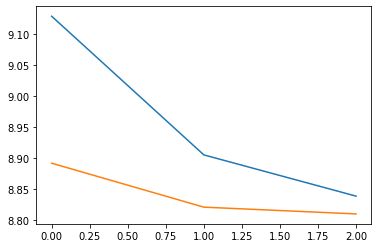

,Epoch,Train RMSE,Test RMSE
3,3,8.794755,8.787356


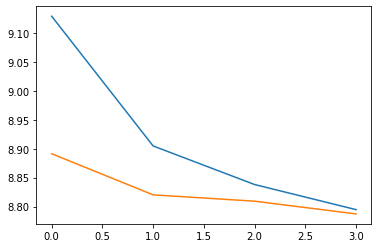

,Epoch,Train RMSE,Test RMSE
4,4,8.766236,8.766919


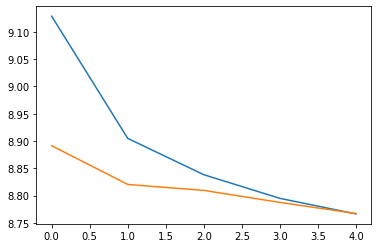

,Epoch,Train RMSE,Test RMSE
5,5,8.742247,8.768111


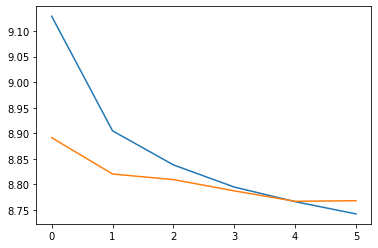

,Epoch,Train RMSE,Test RMSE
6,6,8.73173,8.764582


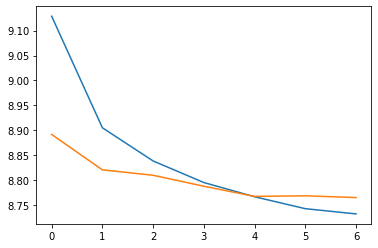

,Epoch,Train RMSE,Test RMSE
7,7,8.715213,8.75749


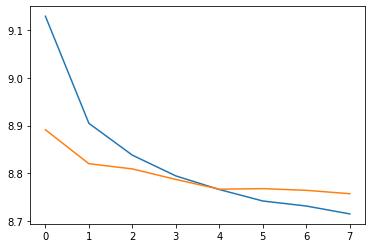

,Epoch,Train RMSE,Test RMSE
8,8,8.711092,8.755325


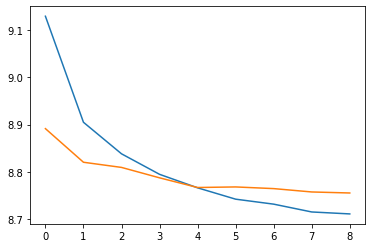

In [ ]:
import matplotlib.pyplot as plt

metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}


train_list = []
test_list = []
    
# Train loop
for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'test']:
        loss_at_stage = 0 
        for batch in dls[stage]:
            model.train()
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

            if stage == 'test':
                model.eval()
            y_pred = model(x_batch.float()).view(-1)
            loss = loss_fn(y_pred, y_batch.float())
            if stage == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()
            with torch.no_grad():
                loss_at_stage += (torch.square((y_pred * ss2.scale_ - y_batch * ss2.scale_)).sum()).item()
        rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
        if stage == 'train':
            train_list.append(rmse_at_stage)
        else:
            test_list.append(rmse_at_stage)
        metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    clear_output
    display(pd.DataFrame(metrics_dict).tail(1))

    
    x1 = [*range(len(train_list))]
    x2 = [*range(len(test_list))]
    plt.plot(x1, train_list)
    plt.plot(x2, test_list, '-')
    plt.show()



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

***Я перебрала множество значений гиперпараметров (lr, batch_size, seed) и архитектур. Давайте я расскажу о некоторых из них, на которых я набила шишки и в конечном счёте получила мою финальную версию.***

*В первой версии я не написала строчки model.train() и model.eval(), которые сообщают модели что сейчас мы тренируем модель и тестрируем соответственно. В итоге из-за этого я получала на тесте RMSE не меньше 10, в то время как на трейне он был нормальным (от 9 до 8.7).*

*Во второй версии, после того как я добавила строчки model.train() и model.eval() я стала получать разумные значения RMSE и на трейне, и на тесте. Но значения на тесте были не меньше 8.8. В итоге я начала подбирать оптимальные значения гиперпараметров lr, batch_size, gamma, seed. Подбирала каждый из параметров я разными способами. Значения гиперпараметров gamma и seed я брала смотря на документацию PyTorch, когда на примеры в ней: я брала значения близкие к тем, что использовались в примерах. В результате я поняла, что gamma должна быть близка к 1 и обычно берут значения в районе 0.9995-0.9999. 

Seed же я пробовала брать аналогично, и я увидела, \
что значение в районе 100 мне подходил лучше всего. 

Значения для lr и batch_size я тоже подбирала аналогичным образом, и в результате через несколько подборов я заметила, что чем меньше значение lr, тем медленнее сходится лосс, но тем лучше обучается модель и значение лосса на тестовой уменьшается. С batch_size было наоборот: я брала значения каждый раз побольше, но не слишком большое, что в результате это привело к улучшению значений лосса. Также я попробовала 2-3 оптимизатора, но я заметила, что Adam справлялся с задачей лучше чем SGD и AdamW. Также я использовала schedule ExponentialLR для того чтобы после кажой итерации у меня уменьшался lr и лосс лучше сходился.*

*Во всех предыдущих версиях я использовала маленькую нейронную сеть от 1 до 2 слоёв. В последующих версиях я начала менять и подбирать гиперпараметры для архитекуры нейронной сети, а именно, число скрытых нейронов, число слоёв, где делать dropout и batchnorm. В итоге я пришла к выводу, что batchnorm нужно делать после каждого линейного преобразования, кроме последнего преобразования, а dropout перед приминением нелинейной функции, кроме последнего слоя.*

*Таким образом, я получила мою конечную архитектуру нейронной сети, которая равномерно сходится к RMSE<=8.76.*